In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import re
import datetime
import cmocean
import colorcet as cc
import cftime
import calendar

import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
hot_dry = True
hot_wet = False
# Call in certain files for different compound events
if hot_dry:
    ces_qpm_sorted = xr.open_dataset('/Users/aedwyer/Documents/CESM_data/QuantilesPerMonth_90T_10P_1850_2100_w1850_1900_PooledQuant.nc')
elif hot_wet:
    ces_qpm_sorted = xr.open_dataset('/Users/aedwyer/Documents/CESM_data/QuantilesPerMonth_90T_90P_1850_2100_w1850_1900_PooledQuant.nc')

In [3]:
ces_qpm_sorted_sum = ces_qpm_sorted['TREFHT'].sel(member = slice(0,50)).sum(dim = 'member')
ces_qpm_sorted_sum_2 = ces_qpm_sorted['TREFHT'].sel(member = slice(50,100)).sum(dim = 'member')
ces_qpm_sorted_sum_total = ces_qpm_sorted_sum + ces_qpm_sorted_sum_2

ensemble_average_CEs = ces_qpm_sorted_sum_total / 100
lat = ensemble_average_CEs['lat']
lon = ensemble_average_CEs['lon']

ERA5

In [44]:
era5 = xr.open_dataset('/Users/aedwyer/Documents/CESM_data/Regridded_ERA5.nc')
expver1 = era5.sel(expver = 1)


### PREPROCESSING ###

seconds_per_month = []

for year in range(1940, 2024):  
    for month in range(1, 13):
        days_in_month = calendar.monthrange(year, month)[1]
        seconds_in_month = 24 * 60 * 60 # * days_in_month
        seconds_per_month.append(seconds_in_month)

# Create a DataArray for seconds per month
seconds_per_month_da = xr.DataArray(seconds_per_month, dims=('time',), coords={'time': era5['time'][:1008]})

total_precip_rate = expver1['tp'][:1008] / seconds_per_month_da  # Seconds in a month
total_precip_rate = total_precip_rate[:1008]
temps = expver1['t2m'][:1008] - 273.15

surface_temps = expver1['skt'][:1008] - 273.15


### COMPOUND EVENT CALCULATION ###
sum_freq = 0

month_indices_trefht = surface_temps.groupby('time.month')
month_indices_prect = total_precip_rate.groupby('time.month')

month_indices_trefht_quants = surface_temps[:360].groupby('time.month')
month_indices_prect_quants = total_precip_rate[:360].groupby('time.month')

# Find Quantiles
trefht_quants = [month_indices_trefht_quants[i].quantile(0.90, dim='time') for i in range(1, 13)]
prect_quants = [month_indices_prect_quants[i].quantile(0.10, dim='time') for i in range(1, 13)]

ce_binary = xr.zeros_like(surface_temps)

for i in range(1, 13):
    trefht_month = month_indices_trefht.groups[i]
    prect_month = month_indices_prect.groups[i]
    ce_binary[trefht_month] = ((surface_temps[trefht_month] >= trefht_quants[i-1]) & 
                                (total_precip_rate[prect_month] <= prect_quants[i-1])) * 1
    

# add the frequency to the sum
sum_freq = ((ce_binary == 1).sum(axis = 0) / len(ce_binary['time'])) * 100

If we are using ensemble average

In [4]:
ensemble_average_CEs = ces_qpm_sorted_sum_total / 100
lat = ensemble_average_CEs['lat']
lon = ensemble_average_CEs['lon']

ce_list = []
i = 0
while i <= len(ensemble_average_CEs['time']) - 60:
    ce_list.append(((ensemble_average_CEs[i:i + 60]).sum(dim='time')))
    i += 12
########################################################################################

toe_array = xr.DataArray(ce_list, coords = {'time': np.arange(1850, 1850 + len(ce_list)), 'lat': lat, 'lon': lon}, dims = ['time','lat', 'lon'])

data_loc = toe_array.sel(lat = lat_c, lon = lon_c, method = 'nearest')
quant_ens = np.quantile(data_loc[:50], 0.90)

# check when the variable moves above the threshold
above_threshold = data_loc > quant

NameError: name 'lat_c' is not defined

Timeseries for CEs and the Median to demonstrate ToE

2.0


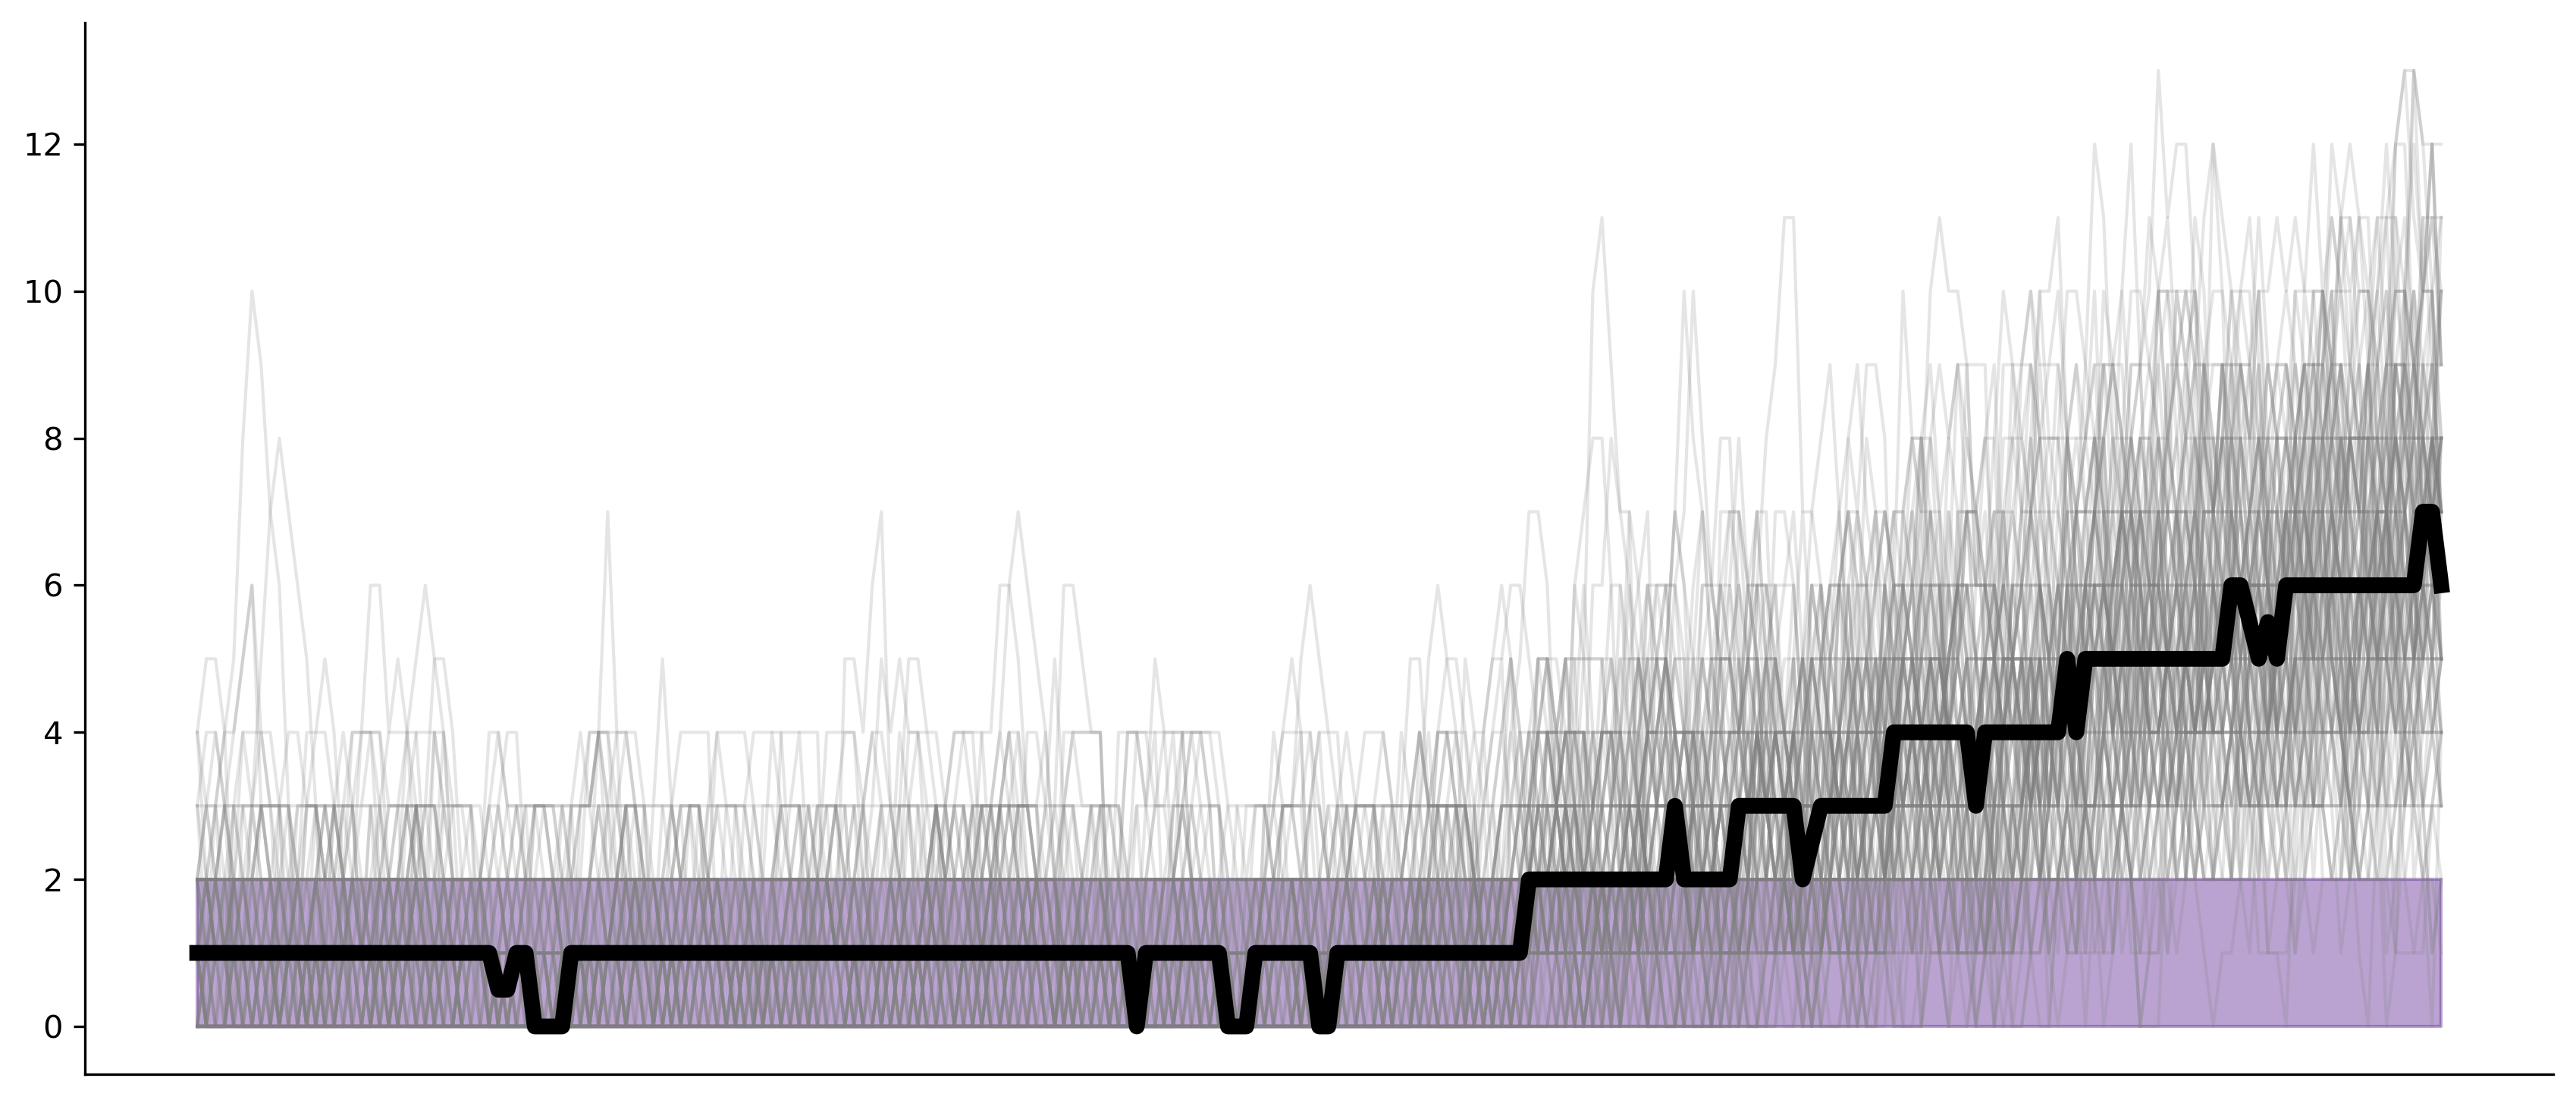

very nice, great sucess


In [18]:
ERA5 = False
lat_c = 38.17
lon_c = 360-96.2

plt.figure(figsize=(14, 6))

all_members_list_one_loc = []
for mem in ces_qpm_sorted['TREFHT']:
    ce_list = []
    i = 0
    while i <= len(ensemble_average_CEs['time']) - 60:
        ce_list.append(((mem[i:i + 60].sel(lat = lat_c, lon = lon_c, method = 'nearest')).sum(dim='time')))
        i += 12
    all_members_list_one_loc.append(ce_list)
    plt.plot(np.arange(1850, 1850 + len(ce_list), 1), ce_list, alpha = 0.2, color = 'gray', linewidth = 1)

# Convert all_members_list_one_loc to a Numpy 
all_members_list_one_loc = np.array(all_members_list_one_loc)

# Compute the median across all members at each point in time
median_ce_list = np.median(all_members_list_one_loc, axis=0)
quant = np.quantile(all_members_list_one_loc[:, :50], q = 0.90)
print(quant)

above_threshold = median_ce_list > quant
#plt.plot(np.arange(1850, 1850 + len(ce_list), 1), data_loc, marker = 'o', color = 'black' )
plt.fill_between(np.arange(1850,1850 + len(ce_list),1), 0, quant, color='rebeccapurple', alpha=0.45, label='Bottom 90 Percent of Baseline')
#plt.ylim(1000, 3300)
plt.plot(np.arange(1850, 1850 + len(median_ce_list), 1), median_ce_list, color='black', label='Median', linewidth = 5)

if ERA5:
    ### EREA5 ADDITION ###
    ce_list = []
    i = 0
    while i <= len(ce_binary[:1008]['time']) - 60:
        ce_list.append((ce_binary[i:i + 60].sel(lat = lat_c, lon = lon_c, method = 'nearest')).sum(dim='time'))
        i += 12
    plt.plot(np.arange(1940, 1940 + len(ce_list), 1), ce_list, alpha = 1, color = 'green', linewidth = 5)

# Remove the top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#plt.xlabel("Time (Year)", size = 22)
#plt.ylabel("Compound Event Count", size = 22)
#plt.title("Central United Kingdom", size = 24)
plt.xticks([])
#plt.yticks(range(0,20,2), fontsize=18)
#plt.legend()

plt.show()

print("very nice, great sucess")

To test for one location the last false value

In [10]:
# Find the indices of all false values
above_threshold = xr.DataArray(above_threshold, coords = {'time': np.arange(1850, 1850 + len(above_threshold))}, dims = ['time'])
false_indices = np.where(above_threshold.values == False)[0]

# Get the last index of False, if there are any
if false_indices.size > 0:
    last_false_index = false_indices[-1]  # Get the last occurrence
    last_false_date = above_threshold.indexes['time'][last_false_index].item()
    print(f"\nThe last false value is at: {last_false_date} with value: {above_threshold[last_false_index].item()}")
else:
    print("\nThere are no false values in the array.")


The last false value is at: 1965 with value: False


Global TOE with 30 year window above 90th quantile

247


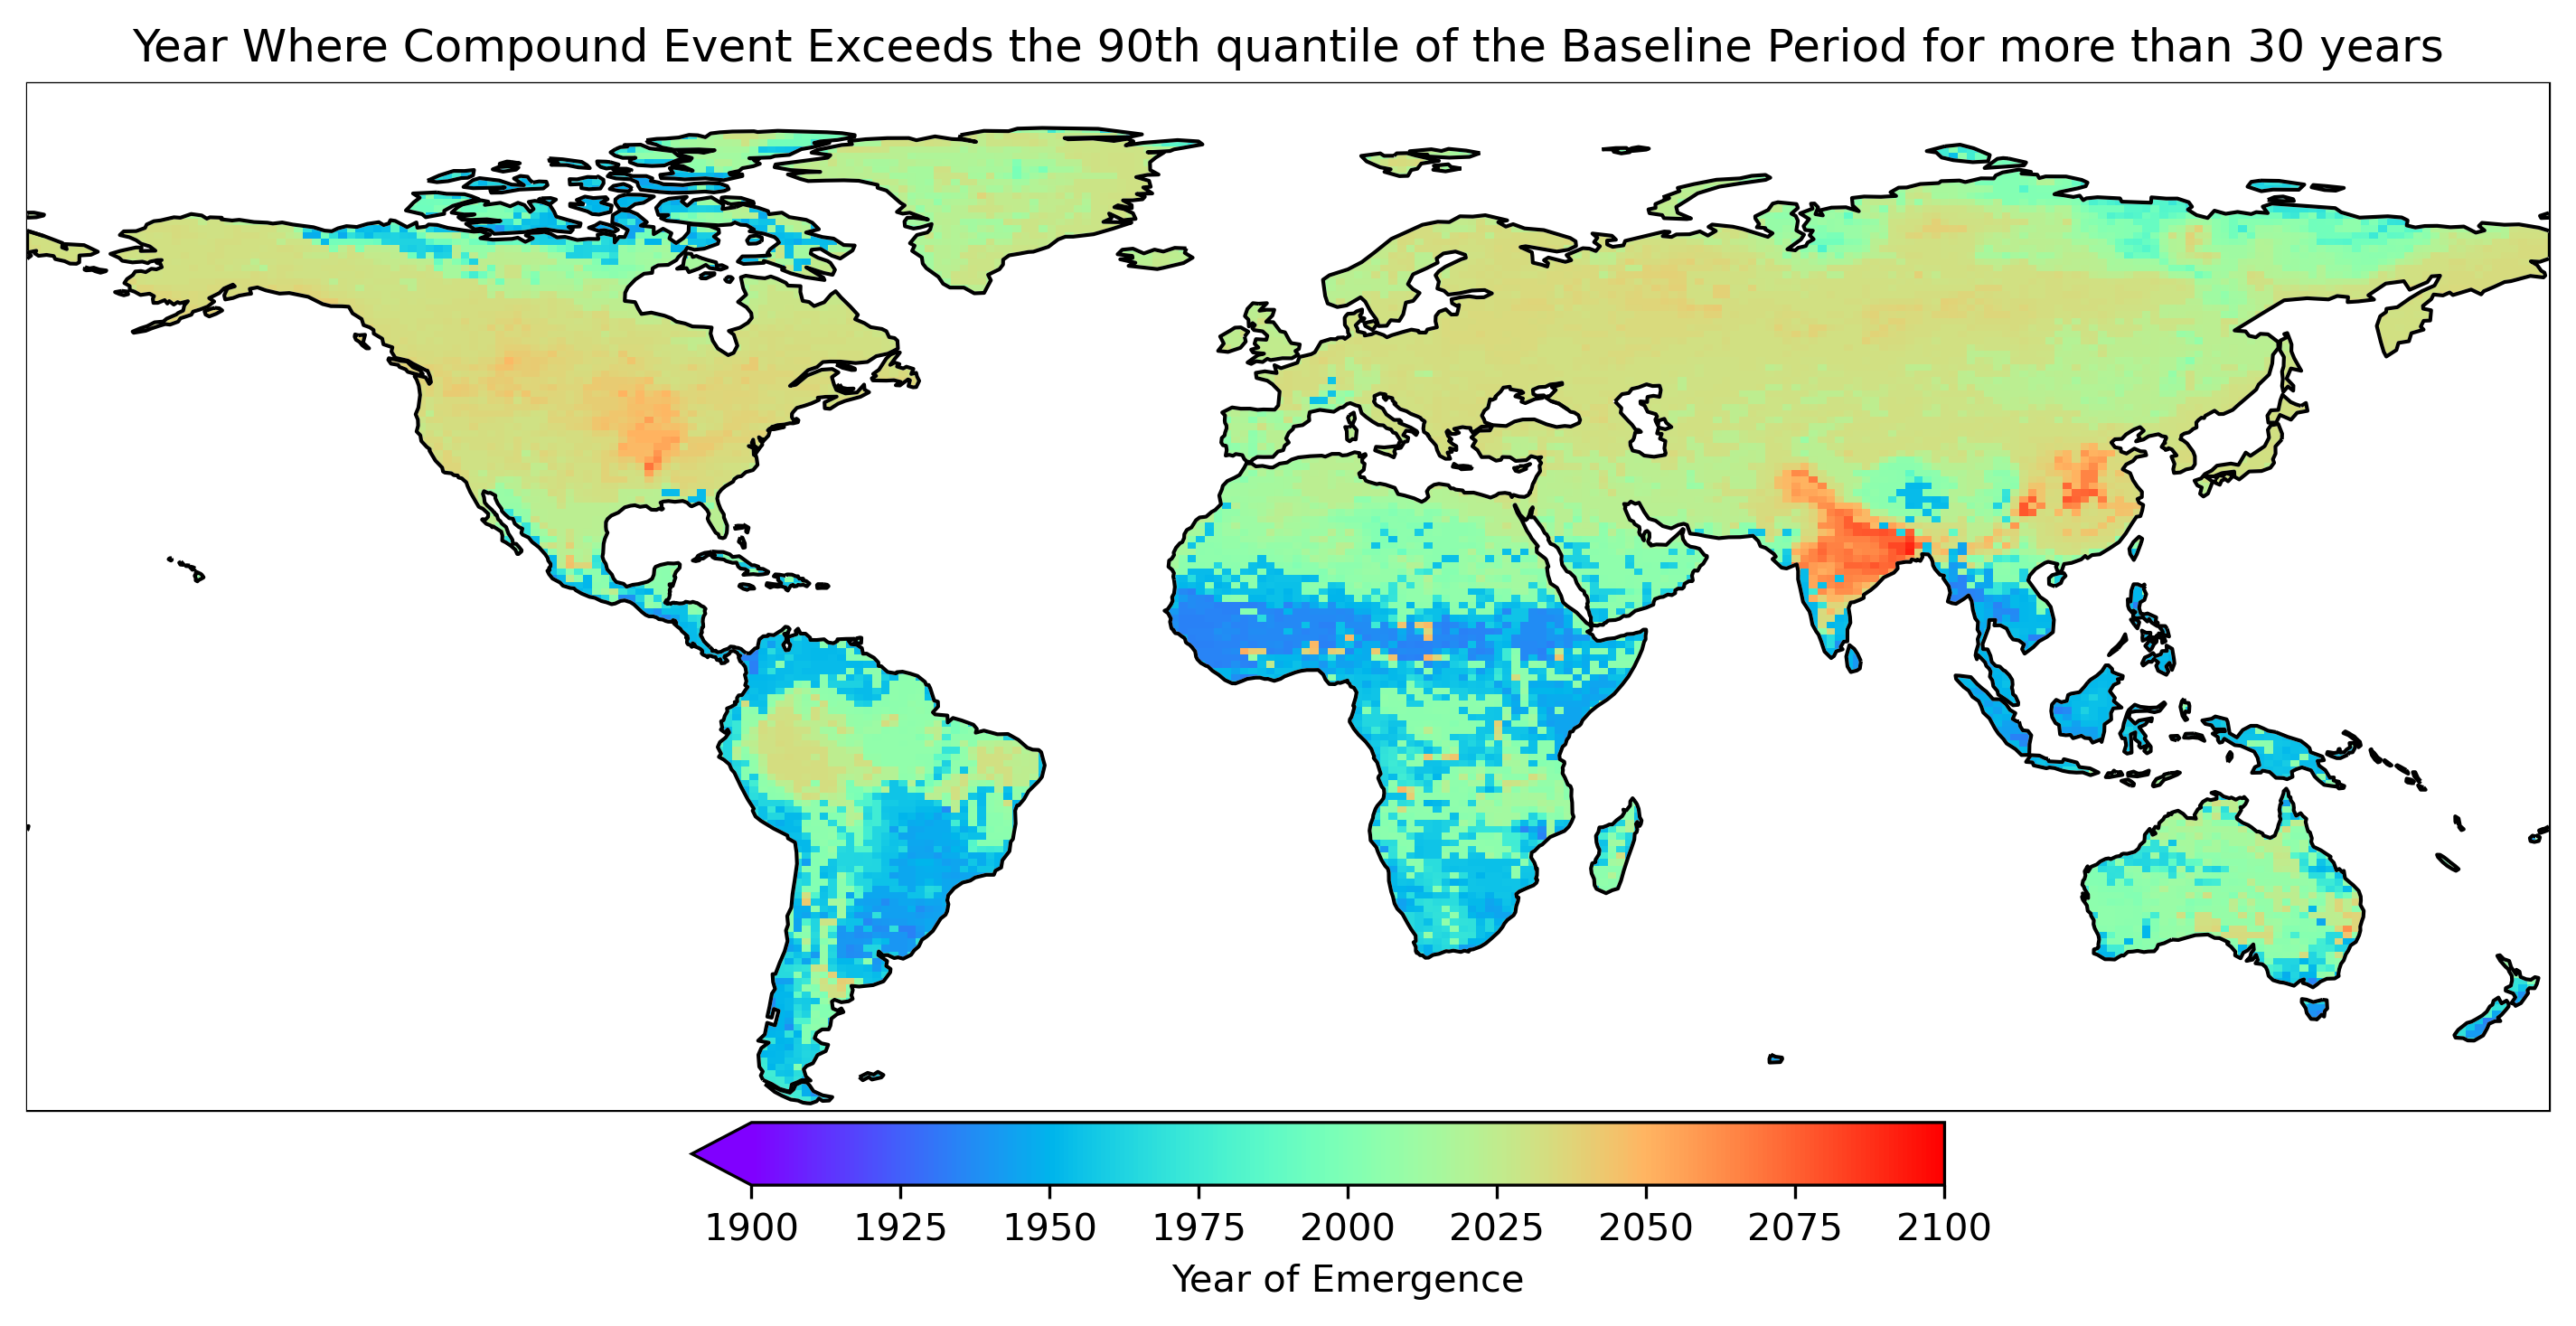

Very Nice, Great Success


In [118]:
ensemble_average_CEs = ces_qpm_sorted_sum_total / 100
lat = ensemble_average_CEs['lat']
lon = ensemble_average_CEs['lon']

ce_list = []
i = 0
while i <= len(ensemble_average_CEs['time']) - 60:
    ce_list.append(((ensemble_average_CEs[i:i + 60]).sum(dim='time')))
    i += 12
########################################################################################

toe_array = xr.DataArray(ce_list, coords = {'time': np.arange(1850, 1850 + len(ce_list)), 'lat': lat, 'lon': lon}, dims = ['time','lat', 'lon'])

print(len(ce_list))
data_loc = toe_array #.sel(lat = -2.85, lon = 360 - 52.52, method = 'nearest')
quant = np.quantile(data_loc[:50], 0.90, axis = 0)
#quant = data_loc[:11].quantile(0.90, dim = 'time')

# check when the variable moves above the threshold
above_threshold = data_loc > quant


mask_int = above_threshold.astype(int)

# window size for checking consecutive True values
window_size = 40

#  rolling window sum along the time dimension
rolling_sum = mask_int.rolling(time=window_size, center=False).sum()

# Find where the rolling sum equals the window size
three_consecutive_true = rolling_sum == window_size


# Use xarray's built-in argmax along the 'time' dimension to get the first occurrence where the condition is True
first_exceed_time_index = three_consecutive_true.argmax(dim='time', skipna=True)

# Convert the index back to time values
first_exceed_time = data_loc.time[first_exceed_time_index]


# Apply latitude bounds to exclude Antarctica
lat_bounds = -57

#  exclude latitudes below the bound
ces_given_enso_filtered = first_exceed_time.where(first_exceed_time['lat'] > lat_bounds, drop=True)

# Convert ces_given_enso_filtered to float and ensure no object-type data remains
#ces_given_enso_filtered_year = ces_given_enso_filtered.time.dt.year

# Optionally fill NaN values with a specific number (e.g., np.nan, or 0 if you want)
#ces_given_enso_filtered_year = ces_given_enso_filtered_year.fillna(np.nan)


# Extract the filtered latitude and longitude values
lon = ces_given_enso_filtered['lon']
lat = ces_given_enso_filtered['lat']

# Plot the figure
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lon, lat, ces_given_enso_filtered, cmap='rainbow', transform=ccrs.PlateCarree(), vmin = 1900, vmax = 2100)
cbar = plt.colorbar(orientation = 'horizontal', pad = 0.01, extend = 'min', fraction = 0.05, label = 'Year of Emergence')

ax.add_feature(cfeature.OCEAN, zorder=100, edgecolor='k', color='white')
ax.add_feature(cfeature.COASTLINE, zorder=101, edgecolor='black')

plt.title("Year Where Compound Event Exceeds the 90th quantile of the Baseline Period for more than 30 years")


plt.savefig('TOE_Test_wBaseline', dpi = 300)
plt.show()

print("Very Nice, Great Success")

Global ToE with point of no return

In [29]:
# Take the ensemble average so you can pull out the lat, lon and the length of the timeseries for later. 
ensemble_average_CEs = ces_qpm_sorted_sum_total / 100
lat = ensemble_average_CEs['lat']
lon = ensemble_average_CEs['lon']

# Initialize loop to go through all the members and take the 5 year moving average sum. Ending 5 years before the end of the time period
# Each 5 year moving sum timeseries for each member is then added to the all_members_list for manipulation later
all_members_list = []
for mem in ces_qpm_sorted['TREFHT']:
    ce_list = []
    i = 0
    while i <= len(ensemble_average_CEs['time']) - 60:
        ce_list.append(mem[i:i + 60].sum(dim='time'))
        i += 12
    all_members_list.append(ce_list)

# Convert all_members_list to a np array
all_members_list = np.array(all_members_list)

# Compute the median across all members at each point in time (axis = 0)
# convert to the median to an xarray to get the set lat and lons to compare to the quant calculation
# find the quantile for the first 50 time indies of all the members for every gridbox
median_ce_list = np.median(all_members_list, axis=0)
median_ce_list = xr.DataArray(median_ce_list, coords = {'time': np.arange(1850, 1850 + len(median_ce_list)), 'lat': lat, 'lon': lon}, dims = ['time','lat', 'lon'])
print(median_ce_list.shape)

quant = np.quantile(all_members_list[:, :50], q = 0.90, axis = (0,1))
quant = xr.DataArray(quant, coords = { 'lat': lat, 'lon': lon}, dims = ['lat', 'lon'])
print(quant.shape)

# find when the median_ce_list is above or below the quantile
above_threshold = median_ce_list > quant

# Create a new DataArray initialized with NaNs, matching the shape of lat-lon grid from above_threshold
#  lat and lon dimensions of 'above_threshold', but only 2D (no time dimension for the result).
last_false_dates = xr.full_like(above_threshold.isel(time=0), np.nan, dtype=float)

# Loop over each latitude and longitude grid point
for lat_idx in range(above_threshold.shape[1]):  # Looping over latitude dimension
    for lon_idx in range(above_threshold.shape[2]):  # Looping over longitude dimension
        
        # Get the timeseries for the current grid point (lat, lon)
        grid_timeseries = above_threshold[:, lat_idx, lon_idx]  # Extract timeseries for a single lat-lon point
        
        # Find the indices of all False values for the current grid point
        false_indices = np.where(grid_timeseries.values == False)[0]
        
        # If there are any False values, get the last False value's index and corresponding date
        if false_indices.size > 0:
            last_false_index = false_indices[-1]  # Get the index of the last False value
            last_false_date = above_threshold.time[last_false_index].values  # Extract the corresponding date
            last_false_dates[lat_idx, lon_idx] = last_false_date + 1  # Assign the last false date + 1 to the 2D grid
        # If no False values, it remains NaN

# Now `last_false_dates` contains the last False date for each grid point
# if the last_false_date is below 2097 it stays as it is, but if it is above 2097 then we make it 2200 so we can turn it white more easily in the colorbar
last_false_dates = last_false_dates.where(last_false_dates < 2097, 2200)

(247, 192, 288)
(192, 288)


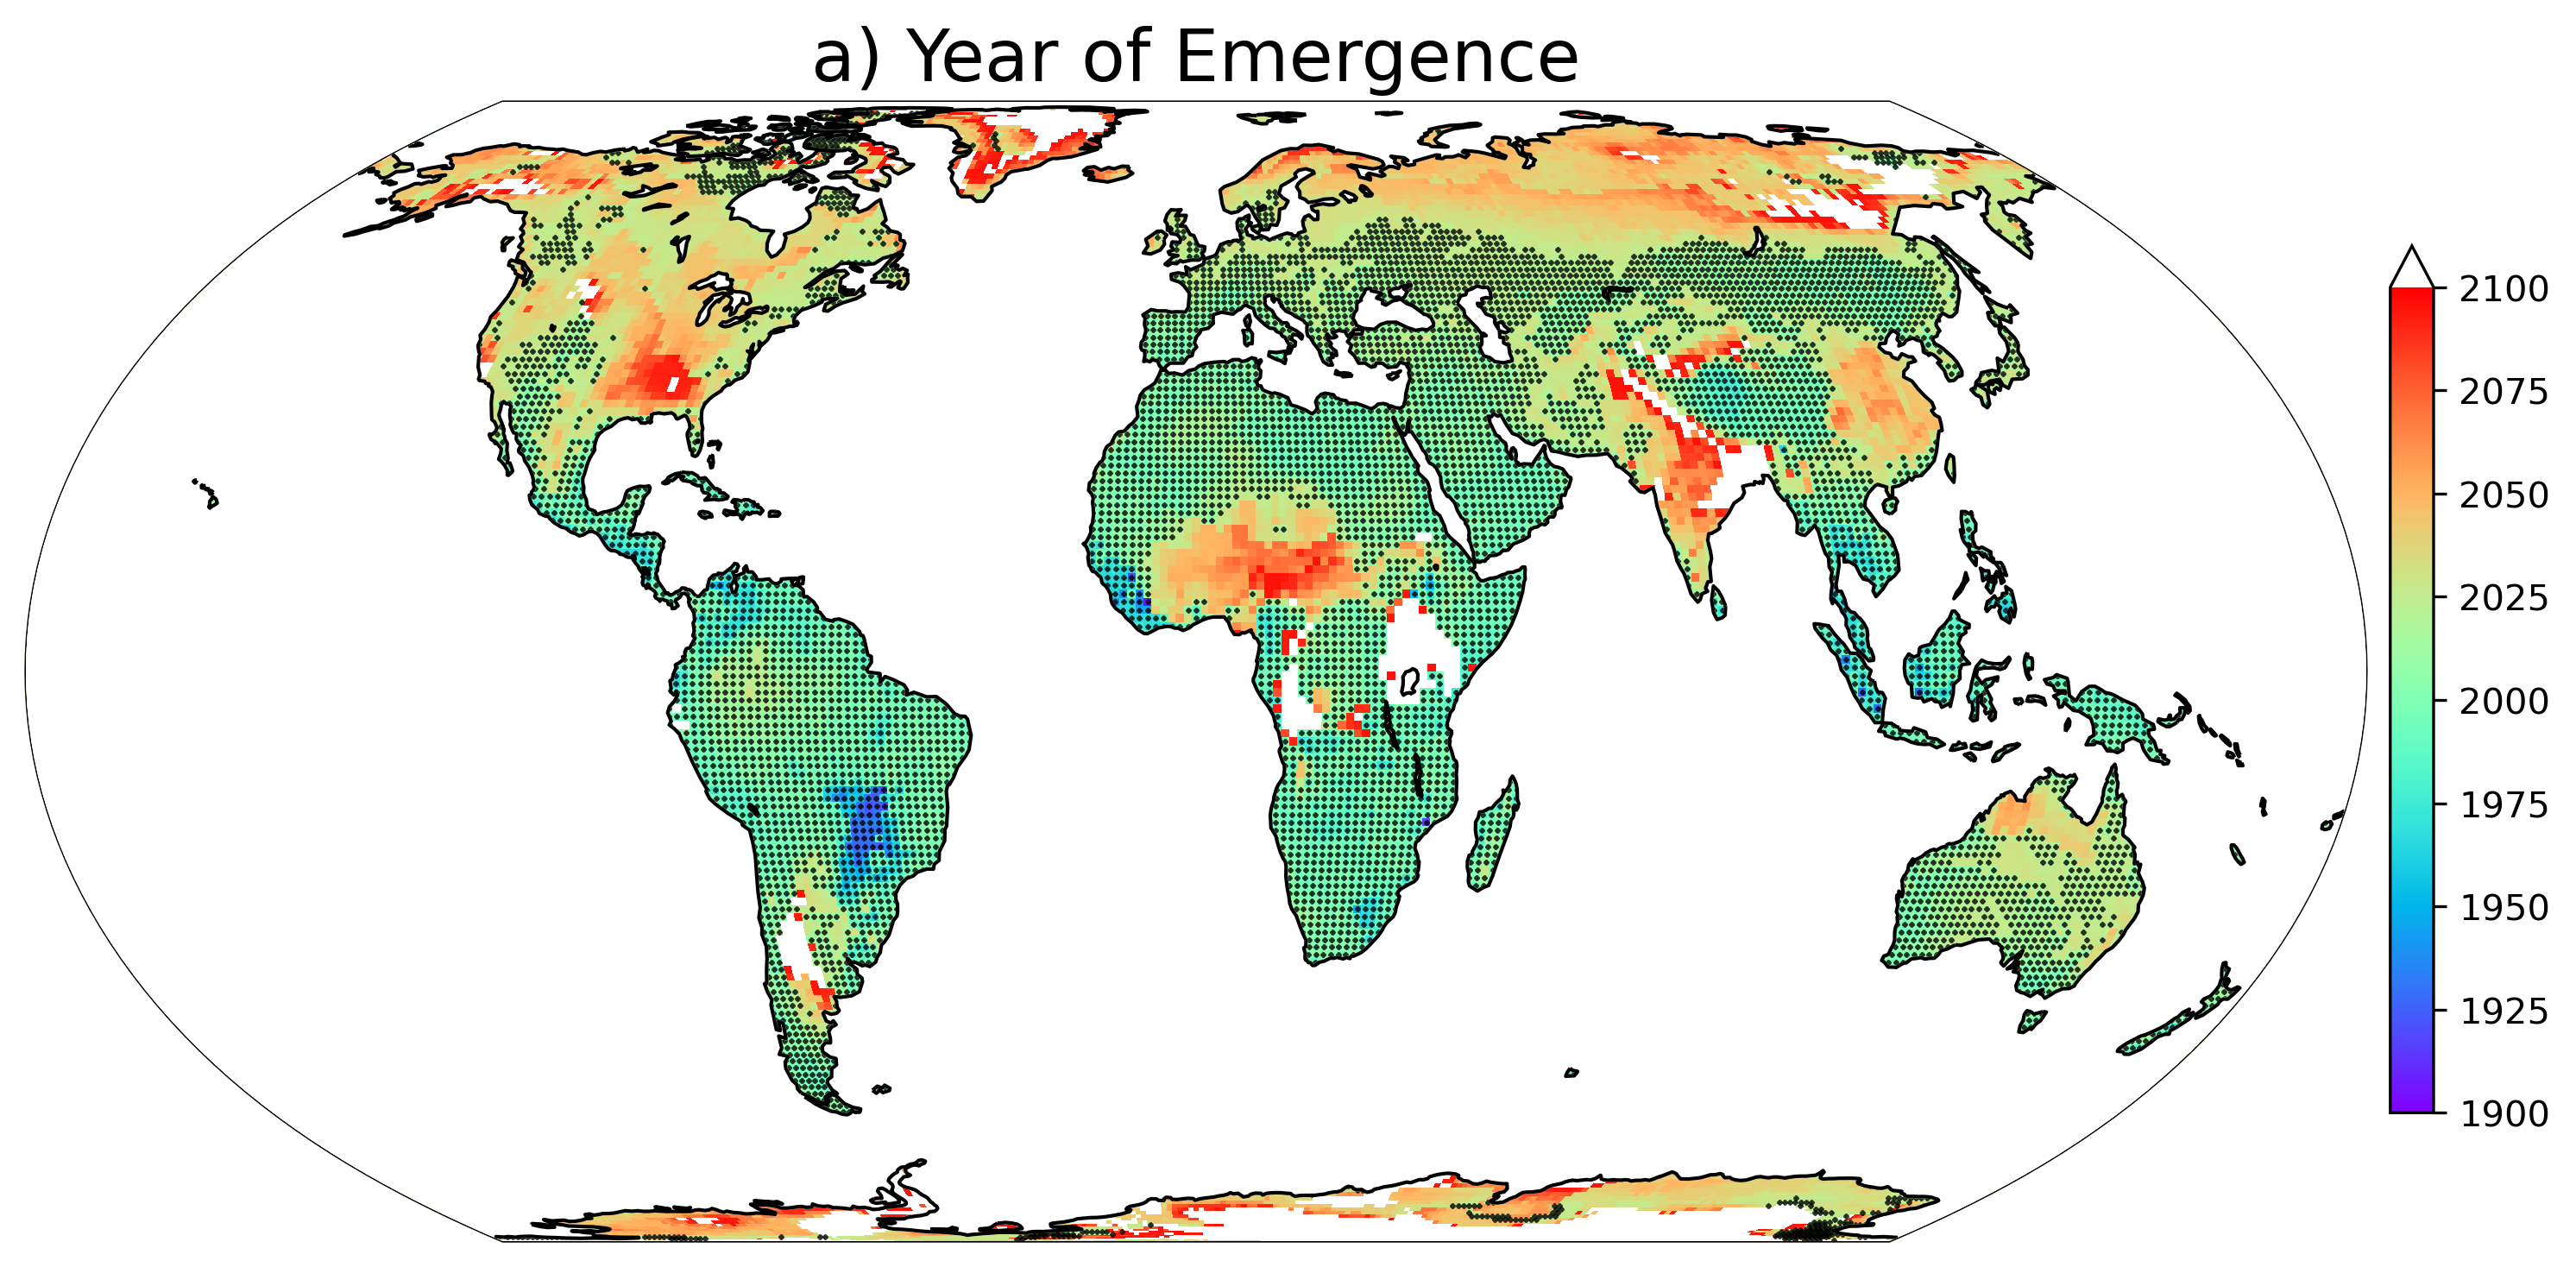

In [32]:
stipple_bool = True

# Apply latitude bounds to exclude Antarctica
lat_bounds = -57

# Filter the xarray DataArray to exclude latitudes below the bound
#toe_plot = last_false_dates.where(last_false_dates['lat'] > lat_bounds, drop=True)

# Extract the filtered latitude and longitude values
lon = last_false_dates['lon'] #toe_plot['lon']
lat = last_false_dates['lat'] #toe_plot['lat']

# Plot the figure
plt.figure(figsize=(12, 6))
cmap = plt.get_cmap('rainbow')
cmap.set_over('white') 
ax = plt.axes(projection=ccrs.EqualEarth())


pcm = plt.pcolormesh(lon, lat, last_false_dates, cmap= cmap, transform=ccrs.PlateCarree(), vmin = 1900, vmax = 2100, zorder = 100)
if stipple_bool:
    mask = last_false_dates < 2025
    stipple_lon, stipple_lat = np.meshgrid(lon, lat)
    plt.scatter(stipple_lon[mask], stipple_lat[mask], marker = 'x', s = 1, linewidth = 1,  color = 'black', alpha = 0.8, transform=ccrs.PlateCarree(), zorder=100)

# Add markers
locations = [(360-51.63, -20.72), (360 - 88.19, 35.33), (13.93, 12.29), 
             (2.99, 48.19), (114.02, -0.54), (87.80, 23.64)]
#for lon, lat in locations:
    #plt.plot(lon, lat, transform=ccrs.PlateCarree(), marker='s', color='black', zorder=101, markersize=8, markerfacecolor='none')

#plt.plot(360-60, -2.85, transform = ccrs.PlateCarree(), marker = 's', color = 'black', zorder = 101, markersize = 8, markerfacecolor = 'none')
#plt.plot(32.50, 5, transform = ccrs.PlateCarree(), marker = 's', color = 'black', zorder = 101, markersize = 8, markerfacecolor = 'none')
#plt.plot(22.80, 50.33, transform = ccrs.PlateCarree(), marker = 's', color = 'black', zorder = 101, markersize = 8, markerfacecolor = 'none')
#plt.plot(17.96, 0.79, transform = ccrs.PlateCarree(), marker = 's', color = 'black', zorder = 101, markersize = 8, markerfacecolor = 'none')



#ax.set_frame_on(False)
cbar = plt.colorbar(pcm, orientation = 'vertical', pad = 0.01, extend = 'max', fraction = 0.018)



ax.add_feature(cfeature.OCEAN, zorder=101, edgecolor='k', color='white')
ax.add_feature(cfeature.COASTLINE, zorder=102, edgecolor='black')
ax.add_feature(cfeature.LAKES, zorder = 102, edgecolor='black', facecolor='white')

#ax.add_feature(cfeature.BORDERS, zorder = 102, edgecolor = 'k')

plt.title("a) Year of Emergence", size = 20)


#plt.savefig('TOE_Test_POINTOFNORETURN', dpi = 300)
plt.show()

In [1]:
land_frac = xr.open_dataset('/Users/aedwyer/Downloads/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.LANDFRAC.185001-185912.nc')

# Apply latitude bounds to exclude Antarctica
lat_bounds = -57

# Filter the xarray DataArray to exclude latitudes below the bound
land_mask = land_frac['LANDFRAC'][0].where(last_false_dates['lat'] > lat_bounds, drop=True)

NameError: name 'xr' is not defined

In [209]:
# Restrict to Hemisphere
hemisphere_mask = last_false_dates['lat'] >= 0 

# Convert latitudes to radians for area weighting
lat_radians = np.deg2rad(last_false_dates['lat'])

# Calculate the area weights (cosine of latitude)
weights = np.cos(lat_radians)

# Apply Southern Hemisphere mask to weights
# If you want the entire globe, comment out the hemisphere mask
weights_hemisphere = weights * hemisphere_mask

# Create a 2D weight array for each grid cell
weights_2d = np.tile(weights_hemisphere, (last_false_dates['lon'].size, 1)).T

# Mask the weights to include only stippled, land cells
stippled_weights = (weights_2d * mask) * land_mask

# Compute stippled land area
stippled_land_area = stippled_weights.sum()

# Apply land mask to weights to account for only land grid cells
land_weights = weights_2d * land_mask 

# Compute land-only total area
total_land_area = land_weights.sum()

# Compute percentage of land area covered by stippled cells
percentage_land_covered = (stippled_land_area / total_land_area) * 100

print(f"Percentage of land area covered by stippled grid boxes: {percentage_land_covered:.2f}%")

Percentage of land area covered by stippled grid boxes: 50.47%
